In [ ]:
import torch
from torch import nn
import numpy as np
from matplotlib import pyplot as plt

torch.__version__

'2.0.1+cu118'

In [ ]:
# Allow access to google drive for working with images
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
sys.path.append("/content/drive/MyDrive/Colab_Notebooks")

In [ ]:
# Setup device-agnoistc code
device = "cuda" if torch.cuda.is_available else "cpu"
device

'cuda'

In [ ]:
# Setting Random Seed for Reproducibility
RANDOM_SEED = 0

# Set seed for torch
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

In [ ]:
# Set Augmentation
AUGMENTATION = True

# File Paths

In [ ]:
from pathlib import Path

# Setup path to data folder
data_path = Path("/content/drive/MyDrive/Colab_Notebooks")
image_path = data_path / "melanoma_cancer_dataset"

# Setup Train and Testing Paths
train_dir = image_path / "train"
test_dir = image_path / "test"

# Visualize the train and test paths
train_dir, test_dir

(PosixPath('/content/drive/MyDrive/Colab_Notebooks/COMP_653_Project/melanoma_cancer_dataset/train'),
 PosixPath('/content/drive/MyDrive/Colab_Notebooks/COMP_653_Project/melanoma_cancer_dataset/test'))

# 2) Image Transformations

In [ ]:
from torchvision import datasets, transforms

# TRAIN DATA TRANSFORMATIONS
train_transform = transforms.Compose([
    # 5% probability of random flip
    transforms.RandomHorizontalFlip(p=0.05),
    # 5% probability of random rotation
    transforms.RandomApply([transforms.RandomRotation(degrees=(-10, 10))], p=0.05),
    # 5% probability of a random colorjittter
    transforms.RandomApply([transforms.ColorJitter(brightness=0.2,
                                                   contrast=0.2,
                                                   saturation=0.2,
                                                   hue=0.2)], p=0.05),
    # Resize the image
    transforms.Resize((300, 300)),
    # Turn Image into a torch.Tensor
    transforms.ToTensor(),
    ])

# Define Transformations for Test Data
# (No Data Augmentation)
test_transform = transforms.Compose([
    # Resize the image
    transforms.Resize((300, 300)),
    # Turn Image into a torch.Tensor
    transforms.ToTensor(),
])

# 3) Defining Training, Validation, and, Testing Data

In [ ]:
from torch.utils.data import random_split

# Percentage Validation Data to Use for Training
VAL_PERC = 0.1

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=test_transform,
                                 target_transform=None)

In [ ]:
print(f"Length of Test: {len(test_data)}")
print()
print(f"Dimensions of Tensorflow Image: {test_data[0][0].shape}")

Length of Test: 2000

Dimensions of Tensorflow Image: torch.Size([3, 300, 300])


# 4) Load data into data loader

In [ ]:
import os
# Define Batch Size and Num_workers
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

In [ ]:
# Turn the train and test datasets into dataloaders
from torch.utils.data import DataLoader

print(f"Creating DataLoaders with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")

# train_dataloader = DataLoader(dataset=train_data,
#                               batch_size=BATCH_SIZE,
#                               num_workers=NUM_WORKERS,
#                               shuffle=True,
#                               drop_last=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=50,
                             num_workers=NUM_WORKERS,
                             shuffle=True)

# val_dataloader = DataLoader(dataset=val_data,
#                             batch_size=BATCH_SIZE,
#                             num_workers=NUM_WORKERS,
#                             shuffle=True,
#                             drop_last=True)

test_dataloader

Creating DataLoaders with batch size 32 and 2 workers.


# 5) Building Model

In [ ]:
from torch import nn
class TinyVGG(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2) # Default stride is same as kernel_size
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*75*75,
                  out_features=output_shape)
    )

  def forward(self, x: torch.Tensor):
    # Optimized for speed
    return self.classifier(self.conv_block_2(self.conv_block_1(x)))

# 6) Loading Trained Model Parameters

In [ ]:
# Model Name
MODEL_NAME = f"Tiny_VGG10_iter_Aug_True"

# The directory to store the model
models_dir = "/content/drive/MyDrive/Colab_Notebooks/COMP_653/"
file_path = models_dir + MODEL_NAME + ".pth"

## Load the Model Parameters

In [ ]:
# Create an instance of the model
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=1).to(device)

# Load the saved model state
model_0.load_state_dict(torch.load(file_path))

<All keys matched successfully>

In [ ]:
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=56250, out_features=1, bias=True)
  )
)

# 8) Test Against Train Data

In [ ]:
from training_script import test as Test


# Define the loss function
# Binary Cross Entropy Loss
loss_fn = nn.BCEWithLogitsLoss()

# Calculate how well the model performed
loss, acc, TP, TN, FN, FP, y_probs, y_test = Test(model_0,
                                                test_dataloader,
                                                loss_fn,
                                                device)

print(f"Model had a Loss of: {loss}")
print(f"Model had an accuracy of: {acc}")
print(f"True Positive (TP): {TP}")
print(f"True Negative (TN): {TN}")
print(f"False Negative (FN): {FN}")
print(f"False Positive (FP): {FP}")

Model had a Loss of: 0.2994768384844065
Model had an accuracy of: 0.8785000000000001
True Positive (TP): 907
True Negative (TN): 850
False Negative (FN): 93
False Positive (FP): 150


In [ ]:
import pickle
# Save the predictions and labels using pickle
PRED_DIR = "/content/drive/MyDrive/Colab_Notebooks/COMP_653/predictions/"

with open(PRED_DIR + MODEL_NAME + "_PRED", "wb") as fp:
  pickle.dump(y_probs, fp)

with open(PRED_DIR + MODEL_NAME + "_TRUE", "wb") as fp:
  pickle.dump(y_test, fp)

In [ ]:
precision = TP / (TP + FP)
recall = TP / (TP + FN)
F1 = (2*precision*recall) / (precision + recall)
accuracy = (TP + TN) / (TP + FN + TN + FP)
specificity = TN / (TN + FP)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {F1}")
print(f"Accuracy: {accuracy}")
print(f"Specificity: {specificity}")

Precision: 0.8580889309366131
Recall: 0.907
F1 Score: 0.8818667963052991
Accuracy: 0.8785
Specificity: 0.85


# 9) Grad-Cam Visualization

In [ ]:
index = 1051

## Import Grad-CAM Package

In [ ]:
try:
  from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
  from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
  from pytorch_grad_cam.utils.image import show_cam_on_image
except:
  !pip install grad-cam
  from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
  from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
  from pytorch_grad_cam.utils.image import show_cam_on_image

## A) Prepare Visualization

In [ ]:
# Select a particular image to look at
img = test_data[index][0]
label = test_data[index][1]



# Select the model and which layer to look at
model = model_0
target_layer = [model.conv_block_2[4]]
input_tensor = img.unsqueeze(0)

# Construct the CAM object then use on many images
cam = GradCAM(model=model, target_layers=target_layer, use_cuda=True)
targets = None
grayscale_cam = cam(input_tensor=input_tensor,
                    targets=targets,
                    aug_smooth=True
                   )

# # Grayscale overlay
grayscale_cam = grayscale_cam[0, :]

# Preparing Original Input Image
rgb_img = img.squeeze(dim=0)

# Do so by dividing by making
# min 0 and max 1 for each channel
chanel1 = rgb_img[0,:,:]
chanel2 = rgb_img[1,:,:]
chanel3 = rgb_img[2,:,:]

rgb_img[0,:,:] = (chanel1 - torch.min(chanel1)) / (torch.max(chanel1) - torch.min(chanel1))
rgb_img[1,:,:] = (chanel2 - torch.min(chanel2)) / (torch.max(chanel2) - torch.min(chanel2))
rgb_img[2,:,:] = (chanel3 - torch.min(chanel3)) / (torch.max(chanel3) - torch.min(chanel3))

# Change Channel Arrangment and make numpy for imshow
rgb_img = img.squeeze(dim=0).permute(1,2,0).numpy().astype(np.float32)

# Generate the Visualization
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

## B) Determine Predicted Label of Image

In [ ]:
# Get the class index dictionary
class_idx = test_data.class_to_idx
idx_class = {v: k for k, v in class_idx.items()}

# Perform a forward pass on a single image
model_0.eval()
with torch.inference_mode():
  pred = model_0(input_tensor.to(device))

pred_label = int(torch.round(torch.sigmoid(pred)).item())
# Print out what's happening and convert model logits -> pred probs -> pred label
print(f"Ouput logits: \n{pred}\n")
print(f"Output prediction probabilities: \n{torch.sigmoid(pred)}\n")
print(f"Ouput prediction label: \n{torch.round(torch.sigmoid(pred))}\n")
print(f"Actual label: \n{label}")

Ouput logits: 
tensor([[4.2500]], device='cuda:0')

Output prediction probabilities: 
tensor([[0.9859]], device='cuda:0')

Ouput prediction label: 
tensor([[1.]], device='cuda:0')

Actual label: 
1


## C) Visualize the Final Image

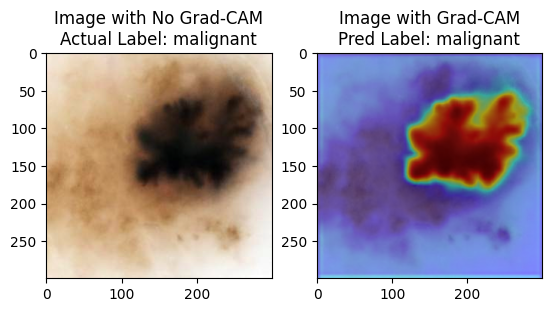

In [ ]:
fig, axs = plt.subplots(1, 2)

# Image 1 (No Grad-CAM)
true_label = idx_class[label]
axs[0].imshow(rgb_img)
axs[0].set_title("Image with No Grad-CAM\n" +
                 f"Actual Label: {true_label}")

# Image 2 (Grad-CAM)
pred_label = idx_class[pred_label]
axs[1].imshow(visualization)
axs[1].set_title("Image with Grad-CAM\n" +
                 f"Pred Label: {pred_label}")
plt.show()

# PHOTOS_DIR = "/content/drive/MyDrive/Colab_Notebooks/photos"
# fig.savefig(PHOTOS_DIR + "/" + MODEL_NAME + "_PHOTO_" + str(index) + ".png")

# 10) ROC Curve

AUC: 0.951222


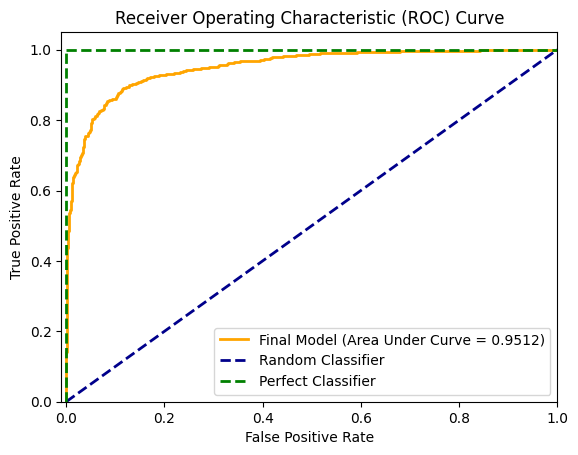

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score, auc

# Calculate the Area Under Curve (AUC)
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)
print("AUC:", roc_auc)

# Plot the ROC curve
fig, axs = plt.subplots()
axs.plot(fpr, tpr,
         color="orange",
         lw=2,
         label=f"Final Model (Area Under Curve = {np.round(roc_auc, 4)})")

axs.plot([0, 1], [0, 1],
         color="darkblue",
         lw=2,
         linestyle='--',
         label="Random Classifier")

axs.plot([0, 1], [1, 1],
         color="green",
         lw=2,
         linestyle='--',
         label="Perfect Classifier")
axs.plot([0, 0], [0, 1],
         color="green",
         lw=2,
         linestyle='--')

axs.set_xlim([-0.01, 1.0])
axs.set_ylim([0.0, 1.05])
axs.set_xlabel('False Positive Rate')
axs.set_ylabel('True Positive Rate')
axs.set_title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()